In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import getpass
%matplotlib inline

In [28]:
username = getpass.getuser()
data = pd.read_csv('/Users/{:}/Dropbox (HMS)/mouse_bandit/markov_full.csv'.format(username), index_col=0)
data = data[data['Condition']=='80-20']
data.head()

,index,Mouse ID,Session ID,Trial,Block Trial,Block Reward,Port Streak,Reward Streak,10_Port,10_Reward,...,1_trialDuration,0_ITI,0_trialDuration,Decision,Switch,Higher p port,Reward,Condition,Block ID,Current Block Length
106400,0,Baby,01112018_Baby,11.0,11.0,5.0,2.0,-2.0,0.0,1.0,...,0.566,1.544,0.560,0.0,1.0,1.0,1.0,80-20,1.0,13.0
106401,1,Baby,01112018_Baby,12.0,12.0,6.0,1.0,1.0,0.0,1.0,...,0.560,2.506,0.497,0.0,0.0,1.0,1.0,80-20,1.0,13.0
106402,2,Baby,01112018_Baby,13.0,0.0,7.0,2.0,2.0,0.0,0.0,...,0.497,2.526,0.562,0.0,0.0,0.0,0.0,80-20,2.0,53.0
106403,3,Baby,01112018_Baby,14.0,1.0,0.0,3.0,-1.0,1.0,0.0,...,0.562,1.780,0.587,0.0,0.0,0.0,0.0,80-20,2.0,53.0
106404,4,Baby,01112018_Baby,15.0,2.0,0.0,4.0,-2.0,0.0,1.0,...,0.587,4.313,0.382,1.0,1.0,1.0,1.0,80-20,2.0,53.0


### make some new dataframes
    X has predictor variables (choice and reward history for past n trials) relevant variables for logit model
    Y has dependent variable (choice on current trial)

In [62]:
#include past 10 choice and reward values (this is most convenient given the current data structure)
port_features = []
reward_features = []
for col in data.columns:
    if '_Port' in col:
        port_features.append(col)
    if '_Reward' in col:
        reward_features.append(col)
        
choice_history = data[port_features]
reward_history = data[reward_features]

switch_cols = ['9_Switch','8_Switch','7_Switch','6_Switch','5_Switch','4_Switch','3_Switch','2_Switch','1_Switch']
switch_history = pd.DataFrame(np.abs(np.diff((choice_history))))
switch_history.columns=switch_cols
switch_history.index=reward_history.index

In [75]:
X_choice = pd.concat([choice_history.drop('10_Port', axis=1), reward_history.drop('10_Reward', axis=1)], axis=1)

X_switch = pd.concat([switch_history, reward_history.drop('10_Reward', axis=1)], axis=1)

X_choice_switch = pd.concat([switch_history, choice_history.drop('10_Port', axis=1), reward_history.drop('10_Reward', axis=1)], axis=1)

X_value_history = (choice_history.values==reward_history.values).astype('int') # gives action value with R=1, L=0

In [78]:
Y_switch_right = data['Decision'] + data['Switch'] == 2
Y_switch_left = data['Decision'].values + data['Switch']*2 == 2
Y_switch_full = data['Switch']

#Y_switch_right_history = (choice_history.drop('10_Port',axis=1).values + switch_history.values) == 2
#Y_switch_left_history = (choice_history.drop('10_Port', axis=1).values + switch_history.values*2) == 2

### set up which datasets will be predictor and target

### lr1 - train on port choice to predict port choice

In [94]:
'''LEFT'''
X_train, X_test, y_train, y_test = train_test_split(X_choice, Y_switch_left, test_size=0.3, random_state=1)

lr1 = LogisticRegression()
lr1.fit(X_train, y_train)

lr1_proba_L = lr1.predict_proba(X_test)
lr1_predict_L = lr1.predict(X_test)
lr1_predict_L = lr1_predict_L>0.2

score_lr1_L = lr1.score(X_test, y_test)
metrics_lr1_L = sklearn.metrics.precision_recall_fscore_support(y_test, lr1_predict_L)

'''RIGHT'''

X_train, X_test, y_train, y_test = train_test_split(X_choice, Y_switch_right, test_size=0.3, random_state=1)

lr1 = LogisticRegression(C=1)
lr1.fit(X_train, y_train)

lr1_proba_R = lr1.predict_proba(X_test)
lr1_predict_R = lr1.predict(X_test)
lr1_predict_R = lr1_predict_R>0.2

score_lr1_R = lr1.score(X_test, y_test)
metrics_lr1_R = sklearn.metrics.precision_recall_fscore_support(y_test, lr1_predict_R)

'''INTEGRATED'''
X_train, X_test, y_train, y_test_full = train_test_split(X_choice, Y_switch_full, test_size=0.3, random_state=1)

y_proba = np.array([max(lr1_proba_L[i,1], lr1_proba_R[i,1]) for i in range(lr1_proba_L.shape[0])])
y_predict = y_proba[:]>0.2
np.sum(y_predict)
metrics_lr1 = sklearn.metrics.precision_recall_fscore_support(y_test_full, y_predict)

In [80]:
metrics_lr1

(array([ 0.96871629,  0.33954802]),
 array([ 0.92476025,  0.56431925]),
 array([ 0.94622806,  0.42398589]),
 array([31074,  2130]))

In [81]:
print('predicted switches left =', np.sum(lr1_predict_L))
print('predicted switches right =', np.sum(lr1_predict_R))
print('overlapping predicted switches =', np.sum(lr1_predict_L + lr1_predict_R ==2))

predicted switches left = 119
predicted switches right = 227
overlapping predicted switches = 0


In [82]:
lr1.get_params()

{'C': 1,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'max_iter': 100,
 'multi_class': 'ovr',
 'n_jobs': 1,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [83]:
# some code for optimizing parameters, come back to later

penalty = ['l1', 'l2']
C = np.logspace(0,4,10)
hyperparameters = dict(C=C, penalty=penalty)
lr_gridsearch = sklearn.model_selection.GridSearchCV(LogisticRegression(), hyperparameters, cv=5, verbose=0)
    
best_model = lr_gridsearch.fit(X_train, y_train)

print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

y_predict = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)

Best Penalty: l1
Best C: 1.0


### take a look at probabilities from each model to switch right or left to compare predictions

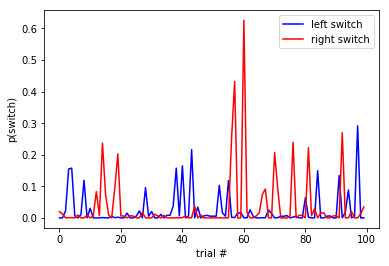

In [84]:
plt.plot(lr1_proba_L[0:100,1], 'b', label='left switch')
plt.plot(lr1_proba_R[0:100,1], 'r', label='right switch')
#plt.plot(Y_switch_left[0:100], '.b', label='true left switch')
#plt.plot(Y_switch_right[0:100], '.r', label='true right switch')

plt.xlabel('trial #')
plt.ylabel('p(switch)')
plt.legend()

### lr2 - train on switches to predict switches

In [87]:
'''LEFT'''
X_train, X_test, y_train, y_test = train_test_split(X_switch, Y_switch_left, test_size=0.3, random_state=1)

lr2 = LogisticRegression()
lr2.fit(X_train, y_train)

lr2_proba_L = lr2.predict_proba(X_test)
lr2_predict_L = lr2.predict(X_test)

score_lr2_L = lr2.score(X_test, y_test)
metrics_lr2_L = sklearn.metrics.precision_recall_fscore_support(y_test, lr2_predict_L)

'''RIGHT'''
X_train, X_test, y_train, y_test = train_test_split(X_switch, Y_switch_right, test_size=0.3, random_state=1)

lr2 = LogisticRegression()
lr2.fit(X_train, y_train)

lr2_proba_R = lr2.predict_proba(X_test)
lr2_predict_R = lr2.predict(X_test)

score_lr2_R = lr2.score(X_test, y_test)
metrics_lr2_R = sklearn.metrics.precision_recall_fscore_support(y_test, lr2_predict_R)

/Users/celiaberon/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### lr3 - use action value to predict choice

In [88]:
'''LEFT'''
X_train, X_test, y_train, y_test = train_test_split(X_value_history, Y_switch_left, test_size=0.3, random_state=1)

lr3 = LogisticRegression()
lr3.fit(X_train, y_train)

lr3_proba_L = lr3.predict_proba(X_test)
lr3_predict_L = lr3.predict(X_test)

score_lr3_L = lr3.score(X_test, y_test)
metrics_lr3_L = sklearn.metrics.precision_recall_fscore_support(y_test, lr3_predict_L)


'''RIGHT'''
X_train, X_test, y_train, y_test = train_test_split(X_value_history, Y_switch_right, test_size=0.3, random_state=1)

lr3 = LogisticRegression()
lr3.fit(X_train, y_train)

lr3_proba_R = lr3.predict_proba(X_test)
lr3_predict_R = lr3.predict(X_test)

score_lr3_R = lr3.score(X_test, y_test)
metrics_lr3_R = sklearn.metrics.precision_recall_fscore_support(y_test, lr3_predict_R)


/Users/celiaberon/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### what about a logistic regression with more inputs?

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X_choice_switch, Y_switch_left, test_size=0.3, random_state=1)

'''Left'''
lr4 = LogisticRegression()
lr4.fit(X_train, y_train)

lr4_proba_L = lr4.predict_proba(X_test)
lr4_predict_L = lr4.predict(X_test)

score_lr4_L = lr4.score(X_test, y_test)
metrics_lr4_L = sklearn.metrics.precision_recall_fscore_support(y_test, lr4_predict_L)

'''RIGHT'''
X_train, X_test, y_train, y_test = train_test_split(X_choice_switch, Y_switch_right, test_size=0.3, random_state=1)


lr4 = LogisticRegression()
lr4.fit(X_train, y_train)

lr4_proba_R = lr4.predict_proba(X_test)
lr4_predict_R = lr4.predict(X_test)
lr4_predict_R = lr4_predict_R>0.1

score_lr4_R = lr4.score(X_test, y_test)
metrics_lr4_R = sklearn.metrics.precision_recall_fscore_support(y_test, lr4_predict_R)

In [106]:
lr4_proba_R[1:100,:]

array([[  9.86542023e-01,   1.34579765e-02],
       [  9.99955090e-01,   4.49095658e-05],
       [  9.99560421e-01,   4.39578843e-04],
       [  9.99523896e-01,   4.76103868e-04],
       [  9.99985988e-01,   1.40124376e-05],
       [  9.91320916e-01,   8.67908425e-03],
       [  9.99991518e-01,   8.48166305e-06],
       [  9.99921645e-01,   7.83548713e-05],
       [  9.92619237e-01,   7.38076261e-03],
       [  9.99990556e-01,   9.44365458e-06],
       [  9.91864719e-01,   8.13528117e-03],
       [  9.13178224e-01,   8.68217765e-02],
       [  9.93294467e-01,   6.70553309e-03],
       [  7.38557897e-01,   2.61442103e-01],
       [  9.28595019e-01,   7.14049811e-02],
       [  9.87956349e-01,   1.20436515e-02],
       [  9.99982787e-01,   1.72125649e-05],
       [  9.08797784e-01,   9.12022164e-02],
       [  8.26214616e-01,   1.73785384e-01],
       [  9.94021517e-01,   5.97848255e-03],
       [  9.94021517e-01,   5.97848255e-03],
       [  9.99963674e-01,   3.63261369e-05],
       [  

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 0.03104176,  0.12483341,  0.21862506,  0.3124167 ,  0.40620835,
         0.5       ,  0.59379165,  0.6875833 ,  0.78137494,  0.87516659,
         0.96895824]),
 <a list of 10 Patch objects>)

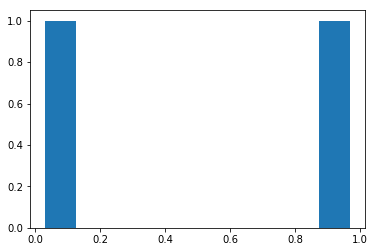

In [102]:
plt.hist(lr4_proba_R)

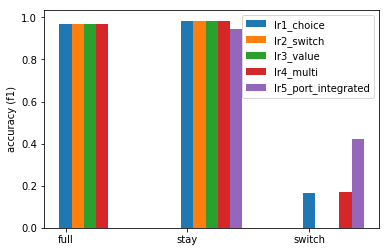

In [100]:
height_a = [score_lr1_R, metrics_lr1_R[2][0], metrics_lr1_R[2][1]]
height_b = [score_lr2_R, metrics_lr2_R[2][0], metrics_lr2_R[2][1]]
height_c = [score_lr3_R, metrics_lr3_R[2][0], metrics_lr3_R[2][1]]
height_d = [score_lr4_R, metrics_lr4_R[2][0], metrics_lr4_R[2][1]]
height_e = [0, metrics_lr1[2][0], metrics_lr1[2][1]]

barWidth = 0.1
# The x position of bars
r1 = np.arange(len(height_b))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]

conditions = ['full', 'stay', 'switch']
plt.bar(r1, height_a, width=barWidth, label='lr1_choice')
plt.bar(r2, height_b, width=barWidth, label='lr2_switch')
plt.bar(r3, height_c, width=barWidth, label='lr3_value')
plt.bar(r4, height_d, width=barWidth, label='lr4_multi')
plt.bar(r5, height_e, width=barWidth, label='lr5_port_integrated')

plt.xticks(range(len(height_b)), conditions)
plt.ylabel('accuracy (f1)')
plt.legend()

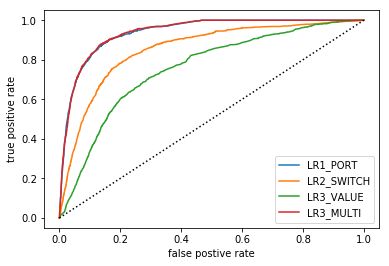

In [91]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(y_test, lr1_proba_R[:,1])
plt.plot(fpr, tpr, label="LR1_PORT")

fpr, tpr, _ = roc_curve(y_test, lr2_proba_R[:,1])
plt.plot(fpr, tpr, label="LR2_SWITCH")

fpr, tpr, _ = roc_curve(y_test, lr3_proba_R[:,1])
plt.plot(fpr, tpr, label="LR3_VALUE")

fpr, tpr, _ = roc_curve(y_test, lr4_proba_R[:,1])
plt.plot(fpr, tpr, label="LR3_MULTI")


plt.plot([0, 1], [0, 1], ':k')
plt.xlabel('false postive rate')
plt.ylabel('true positive rate')

plt.legend(loc='lower right')